In [3]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import io
import numpy as np

In [4]:
def read_data():
    data_path = 'graph_edges.xlsx'
    df = pd.read_excel(data_path)
    return df

In [5]:
def calculate_all_metrics(G):
  """
    Tính toán tất cả các số đo của đồ thị
    Args:
        G: Đồ thị NetworkX
    Returns:
        dict: Dictionary chứa các số đo của đồ thị
  """
  metrics = {}
  # 1. Thông tin cơ bản
  metrics['nodes'] = G.number_of_nodes()
  # |V|: Số lượng đỉnh trong đồ thị

  metrics['edges'] = G.number_of_edges()
  # |E|: Số lượng cạnh trong đồ thị

  metrics['density'] = nx.density(G)
  # Mật độ đồ thị
  # Công thức: D = 2|E| / (|V|(|V|-1))
  # Trong đó:
  # - |E|: số cạnh thực tế
  # - |V|(|V|-1): số cạnh tối đa có thể có trong đồ thị vô hướng

  metrics['average_degree'] = np.mean([d for n, d in G.degree()])

  # 2. Degree metrics
  degrees = dict(G.degree())
  metrics['avg_degree'] = sum(degrees.values()) / len(degrees)
  # Degree trung bình
  # Công thức: <k> = (1/|V|) * Σ ki
  # Trong đó:
  # - |V|: số lượng đỉnh
  # - ki: degree của đỉnh i
  # Note: Trong đồ thị vô hướng: <k> = 2|E|/|V|

  metrics['max_degree'] = max(degrees.values())
  metrics['degrees'] = degrees

  # 3. Degree Centrality
  dc = nx.degree_centrality(G)
  metrics['degree_centrality'] = {
      'values': dc,
      'max': max(dc.values()),
      'avg': sum(dc.values()) / len(dc),
      'node_max': max(dc, key=dc.get)
  }
  # Degree Centrality
  # Công thức: CD(v) = deg(v)/(|V|-1)
  # Trong đó:
  # - deg(v): degree của đỉnh v
  # - |V|-1: số lượng kết nối tối đa có thể có của một đỉnh

  # 4. Betweenness Centrality
  bc = nx.betweenness_centrality(G)
  metrics['betweenness_centrality'] = {
      'values': bc,
      'max': max(bc.values()),
      'avg': sum(bc.values()) / len(bc),
      'node_max': max(bc, key=bc.get)
  }
  # Betweenness Centrality
  # Công thức: CB(v) = Σ (σst(v)/σst)
  # Trong đó:
  # - σst: số đường đi ngắn nhất từ đỉnh s đến đỉnh t
  # - σst(v): số đường đi ngắn nhất từ s đến t đi qua v
  # - Tổng được tính trên mọi cặp đỉnh s,t khác v

  # 5. Closeness Centrality
  cc = nx.closeness_centrality(G)
  metrics['closeness_centrality'] = {
      'values': cc,
      'max': max(cc.values()),
      'avg': sum(cc.values()) / len(cc),
      'node_max': max(cc, key=cc.get)
  }
  # Closeness Centrality
  # Công thức: CC(v) = (|V|-1) / Σ d(v,u)
  # Trong đó:
  # - |V|-1: số đỉnh khác v
  # - d(v,u): độ dài đường đi ngắn nhất từ v đến u
  # - Tổng được tính trên mọi đỉnh u khác v

  # 6. PageRank
  pr = nx.pagerank(G, alpha=0.85)
  metrics['pagerank'] = {
      'values': pr,
      'max': max(pr.values()),
      'avg': sum(pr.values()) / len(pr),
      'node_max': max(pr, key=pr.get)
  }
  # PageRank
  # Công thức: PR(v) = (1-d) + d * Σ (PR(u)/OutDegree(u))
  # Trong đó:
  # - d: damping factor (thường = 0.85)
  # - PR(u): PageRank của các đỉnh u kề với v
  # - OutDegree(u): bậc ra của đỉnh u
  # - Tổng được tính trên mọi đỉnh u kề với v

  return metrics

In [6]:
def visualize_metrics(G, metrics):
    """
    Trực quan hóa các số đo của đồ thị
    Args:
        G: Đồ thị NetworkX
        metrics: Dictionary chứa các số đo của đồ thị
    """
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    ax = axs[0, 0]
    degree_values = list(metrics['degrees'].values())
    ax.hist(degree_values, bins=50, color='skyblue', edgecolor='black')
    ax.set_title('Degree Distribution')
    ax.set_xlabel('Degree')
    ax.set_ylabel('Frequency')

    ax = axs[0, 1]
    centrality_measures = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'pagerank']
    centrality_values = [
        list(metrics['degree_centrality']['values'].values()),
        list(metrics['betweenness_centrality']['values'].values()),
        list(metrics['closeness_centrality']['values'].values()),
        list(metrics['pagerank']['values'].values())
    ]
    
    ax.boxplot(centrality_values, labels=['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'PageRank'])
    ax.set_title('Centrality Comparison')
    ax.set_ylabel('Centrality Value')

    ax = axs[1, 0]
    top_n = 10
    top_degree_nodes = sorted(metrics['degrees'].items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_dc_nodes = sorted(metrics['degree_centrality']['values'].items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_bc_nodes = sorted(metrics['betweenness_centrality']['values'].items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_cc_nodes = sorted(metrics['closeness_centrality']['values'].items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_pr_nodes = sorted(metrics['pagerank']['values'].items(), key=lambda x: x[1], reverse=True)[:top_n]

    top_nodes = {
        'Degree': [x[0] for x in top_degree_nodes],
        'Degree Centrality': [x[0] for x in top_dc_nodes],
        'Betweenness Centrality': [x[0] for x in top_bc_nodes],
        'Closeness Centrality': [x[0] for x in top_cc_nodes],
        'PageRank': [x[0] for x in top_pr_nodes]
    }

    top_values = {
        'Degree': [x[1] for x in top_degree_nodes],
        'Degree Centrality': [x[1] for x in top_dc_nodes],
        'Betweenness Centrality': [x[1] for x in top_bc_nodes],
        'Closeness Centrality': [x[1] for x in top_cc_nodes],
        'PageRank': [x[1] for x in top_pr_nodes]
    }

    bar_width = 0.15
    index = np.arange(top_n)

    ax.bar(index, top_values['Degree'], bar_width, label='Degree', color='skyblue')
    ax.bar(index + bar_width, top_values['Degree Centrality'], bar_width, label='Degree Centrality', color='lightgreen')
    ax.bar(index + 2*bar_width, top_values['Betweenness Centrality'], bar_width, label='Betweenness Centrality', color='salmon')
    ax.bar(index + 3*bar_width, top_values['Closeness Centrality'], bar_width, label='Closeness Centrality', color='orange')
    ax.bar(index + 4*bar_width, top_values['PageRank'], bar_width, label='PageRank', color='purple')

    ax.set_title('Top Nodes Comparison')
    ax.set_xlabel('Nodes')
    ax.set_ylabel('Value')
    ax.set_xticks(index + 2*bar_width)
    ax.set_xticklabels(top_nodes['Degree'])
    ax.legend()

    ax = axs[1, 1]
    degree_centrality_values = list(metrics['degree_centrality']['values'].values())
    betweenness_centrality_values = list(metrics['betweenness_centrality']['values'].values())
    closeness_centrality_values = list(metrics['closeness_centrality']['values'].values())
    pagerank_values = list(metrics['pagerank']['values'].values())

    ax.scatter(degree_values, degree_centrality_values, label='Degree vs Degree Centrality', alpha=0.5, color='blue')
    ax.scatter(degree_values, betweenness_centrality_values, label='Degree vs Betweenness Centrality', alpha=0.5, color='red')
    ax.scatter(degree_values, closeness_centrality_values, label='Degree vs Closeness Centrality', alpha=0.5, color='green')
    ax.scatter(degree_values, pagerank_values, label='Degree vs PageRank', alpha=0.5, color='purple')

    ax.set_title('Degree vs Centrality Comparison')
    ax.set_xlabel('Degree')
    ax.set_ylabel('Centrality Value')
    ax.legend()

    plt.tight_layout()
    plt.show()

In [7]:
def print_detailed_results(metrics):
  """
  In kết quả chi tiết của các phép đo
  """
  print("\n======== PHÂN TÍCH MẠNG XÃ HỘI ========= ")
  print("1. Thông tin cơ bản")
  print(f"- Số lượng nodes (người dùng): {metrics['nodes']}")
  print(f"- Số lượng cạnh (kết nối): {metrics['edges']}")
  print(f"- Mật độ: {metrics['density']}")
  print(f"- Degree trung bình: {metrics['average_degree']}")
  print(f"- Degree lớn nhất: {metrics['max_degree']}")

  centrality_measures = {
        'Degree Centrality': 'degree_centrality',
        'Betweenness Centrality': 'betweenness_centrality',
        'Closeness Centrality': 'closeness_centrality',
        'PageRank': 'pagerank'
    }

  print("2. Các số đo Centrality")
  for name, measure in centrality_measures.items():
    print(f"- {name}")
    print(f"- Giá trị lớn nhất: {metrics[measure]['max']:.4f}")
    print(f"- Giá trị trung bình: {metrics[measure]['avg']:.4f}")
    print(f"- Node có giá trị cao nhất: {metrics[measure]['node_max']}")


In [9]:
df = read_data()
df.head()


,Source,Target
0,61550283796273,100088594703151
1,61550283796273,61550283796273
2,61550283796273,100008345610005
3,61550283796273,61556738729809
4,61550283796273,100095103133859


In [10]:
backup_df = df.copy()

In [12]:
G = nx.from_pandas_edgelist(df, "Source", "Target")
metrics = calculate_all_metrics(G)
print_detailed_results(metrics)


======== PHÂN TÍCH MẠNG XÃ HỘI ========= 
1. Thông tin cơ bản
- Số lượng nodes (người dùng): 398
- Số lượng cạnh (kết nối): 4011
- Mật độ: 0.05077022391554751
- Degree trung bình: 20.155778894472363
- Degree lớn nhất: 155
2. Các số đo Centrality
- Degree Centrality
- Giá trị lớn nhất: 0.3904
- Giá trị trung bình: 0.0508
- Node có giá trị cao nhất: 100082856597891
- Betweenness Centrality
- Giá trị lớn nhất: 0.1012
- Giá trị trung bình: 0.0037
- Node có giá trị cao nhất: 100082856597891
- Closeness Centrality
- Giá trị lớn nhất: 0.6061
- Giá trị trung bình: 0.4163
- Node có giá trị cao nhất: 100082856597891
- PageRank
- Giá trị lớn nhất: 0.0178
- Giá trị trung bình: 0.0025
- Node có giá trị cao nhất: 100082856597891


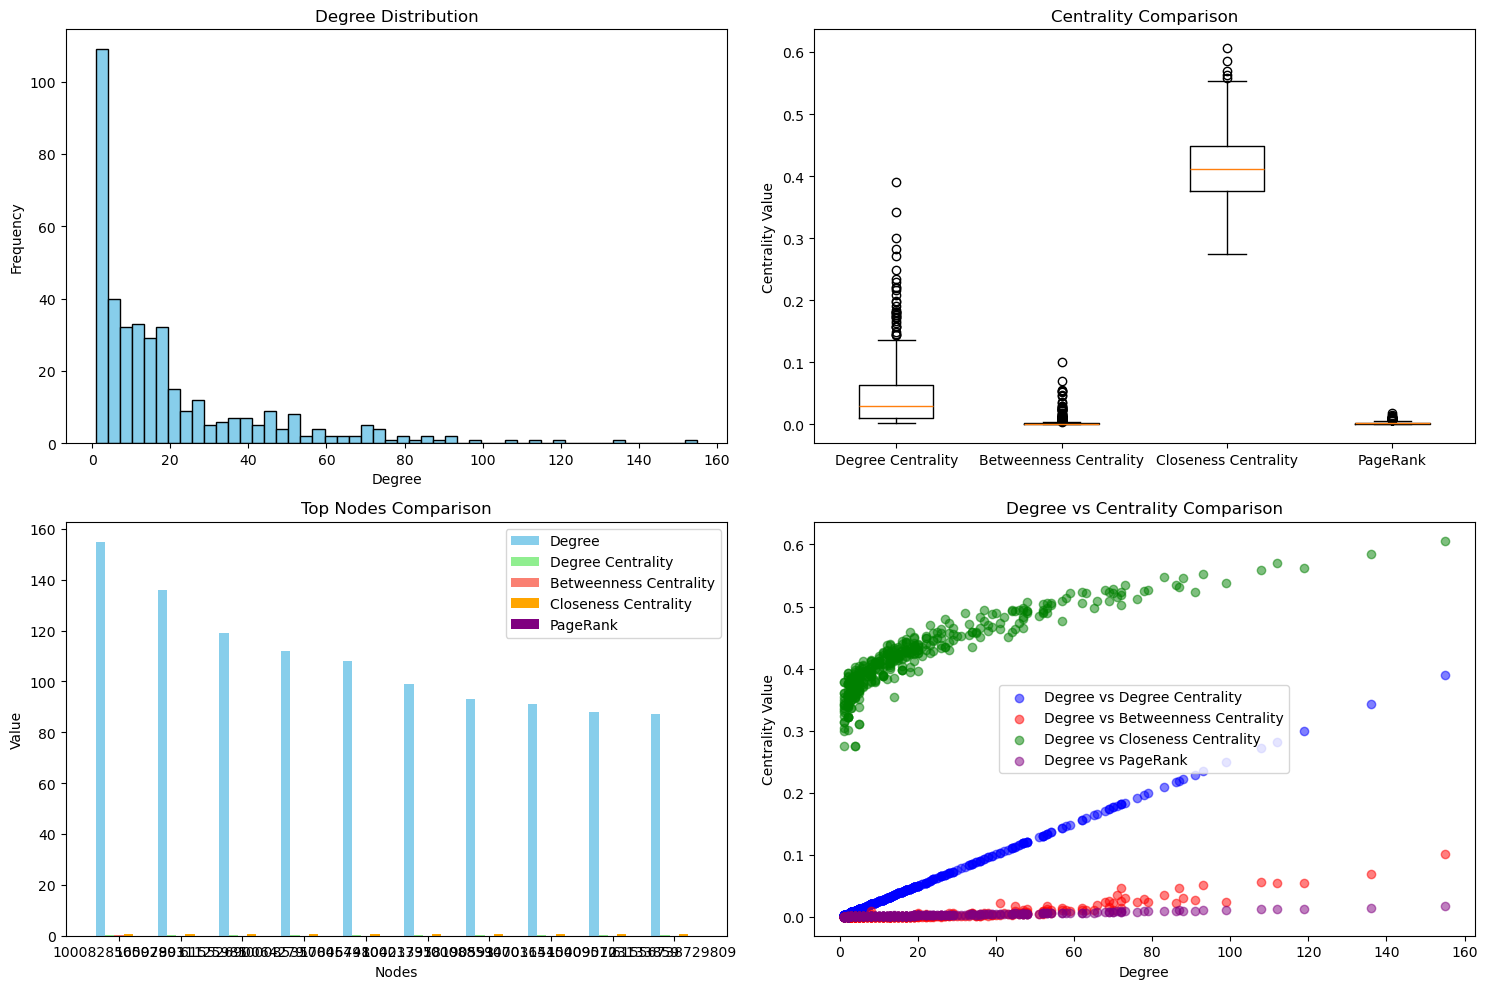

In [13]:
visualize_metrics(G, metrics)